<a href="https://colab.research.google.com/github/Mihail-Olegovich/Spam-prediction/blob/main/%D0%A2%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_%D0%92%D0%9A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install gensim -q

In [2]:
!pip install transformers -q

In [3]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np

In [4]:
from transformers import DistilBertModel
from transformers import AutoTokenizer

In [5]:
import gensim.downloader as api


fasttext = api.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data

In [7]:
train_df = pd.read_csv('/content/drive/MyDrive/Datasets/VK internship/train_spam.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Datasets/VK internship/test_spam.csv')

# EDA

In [ ]:
train_df['text_type'].value_counts()

text_type
ham     11469
spam     4809
Name: count, dtype: int64

In [ ]:
train_df.shape

(16278, 2)

In [ ]:
test_df.shape

(4070, 1)

In [ ]:
train_df['text'].iloc[0]

'make sure alex knows his birthday is over in fifteen minutes as far as youre concerned'

In [ ]:
train_df.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


# Fasttext + CNN

## Vocabulary

In [148]:
import re
import string
from collections import Counter


class Vocabulary:
    def __init__(self, texts: list[str], min_freq: int = 10):
        text = ' '.join(texts)

        text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", text)
        text = re.sub("[^a-zA-Z]", " ", text)

        while '  ' in text:
            text = text.replace('  ', ' ')

        words = text.strip().lower().split()

        c = Counter(words)

        self.vocabulary = list(set([word for word in words if c[word] >= min_freq]))
        self.vocabulary.append('<unk>')
        self._idx2word = {i: word for i, word in enumerate(self.vocabulary)}
        self._word2idx = {word: i for i, word in enumerate(self.vocabulary)}

    def get_vocabulary(self):
        return self.vocabulary

    def idx2word(self, idx: int):
        if idx not in self._idx2word:
            return '<unk>'

        return self._idx2word[idx]

    def word2idx(self, word: str):
        word = word.lower()
        if word not in self._word2idx:
            return self._word2idx['<unk>']

        return self._word2idx[word]

    def encode(self, text):
        result = []

        for word in text.split():
            result.append(self.word2idx(word))

        return result

    def build_vectors(self, fasttext):
        vectors = []

        for word in self.vocabulary:
            if fasttext.has_index_for(word):
                vectors.append(fasttext[word])
            else:
                vectors.append(np.zeros(25))

        return np.stack(vectors)

    def build_vectors_BERT(self, tokenizer, BERT):
        vectors = []

        for word in self.vocabulary:
            embedding = BERT(torch.tensor([tokenizer.encode(word, add_special_tokens=True)])\
                              )['last_hidden_state'][:, 0, :]\
                              .squeeze().detach().numpy()
            vectors.append(embedding)

        return np.stack(vectors)

## Dataset

In [149]:
from torch.utils.data import Dataset


class Messages(Dataset):
    def __init__(self, path_to_train, path_to_oot):
        self.df = pd.read_csv(path_to_train)
        self.df_oot = pd.read_csv(path_to_oot)

        texts = np.concatenate([self.df['text'].values, self.df_oot['text'].values])

        self.vocab = Vocabulary(texts, min_freq=5)

        self.label2idx = {'ham': 0, 'spam': 1}

    def __getitem__(self, idx):
        text = self.df['text'].loc[idx]
        label = self.label2idx[self.df['text_type'].loc[idx]]

        text = torch.LongTensor(self.vocab.encode(text))
        label = torch.FloatTensor([label])

        return text, label

    def __len__(self):
        return len(self.df)

In [150]:
dataset = Messages('/content/drive/MyDrive/Datasets/VK internship/train_spam.csv', '/content/drive/MyDrive/Datasets/VK internship/test_spam.csv')

In [151]:
dataset[3]

(tensor([ 4188,  8826,  3122, 10281,  5150,  6751,  6442,   737,  3911, 11815,
          1955, 11472,  4970, 11815,   470, 11647,  2524,  8503, 11815,  7329,
         11815,  4793, 11815]),
 tensor([1.]))

In [152]:
len(dataset.vocab.vocabulary)

11816

## Train - validation split

In [153]:
from torch.utils.data import random_split


train_dataset, test_dataset = random_split(dataset, (int(len(dataset) * 0.9), len(dataset) - int(len(dataset) * 0.9)))

In [154]:
from torch.nn.utils.rnn import pad_sequence

pad_idx = len(dataset.vocab.vocabulary)

def collate_fn(batch):
    texts = pad_sequence([b[0] for b in batch], padding_value=pad_idx, batch_first=True)
    labels = torch.stack([b[1] for b in batch])

    return texts, labels

In [155]:
from torch.utils.data import DataLoader


train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn, pin_memory=True)

## Model

In [156]:
import torch.nn.functional as F


class TextCNN(nn.Module):
    def __init__(self, vocab_size: int, embedding_dim: int, pad_idx):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.convs = nn.ModuleList(
            [
                nn.Conv2d(
                    in_channels = 1,
                    out_channels = 16,
                    kernel_size = (fs, embedding_dim))
                for fs in [2, 3, 4, 5]
            ]
        )

        self.fc = nn.Linear(4 * 16, 1)

        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(1)

        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs]

        x = [F.max_pool1d(_, _.shape[2]).squeeze(2) for _ in x]

        x = self.dropout(torch.cat(x, dim = 1))

        return self.fc(x)

In [157]:
model = TextCNN(vocab_size=len(dataset.vocab.vocabulary) + 1, embedding_dim=25, pad_idx=pad_idx)

In [158]:
vectors = dataset.vocab.build_vectors(fasttext)

In [159]:
vectors.shape

(11816, 25)

In [160]:
len(dataset.vocab.vocabulary)

11816

In [161]:
vectors[0]

array([ 0.17703   ,  0.18835001, -0.23961   , -1.4483    ,  0.76485997,
       -0.41332   ,  0.18783   , -1.48000002,  1.78180003, -0.36502999,
       -0.78803003,  0.26431   , -1.25919998,  0.51744998,  0.99109   ,
       -0.93414003,  0.89050001,  0.59325999,  1.00279999,  0.19833   ,
       -0.98514998, -0.11207   , -0.2762    , -0.16446   ,  0.19386999])

In [162]:
model.embedding.weight.shape

torch.Size([11817, 25])

In [163]:
model.embedding.weight.data[:len(vectors)] = torch.from_numpy(vectors)

In [164]:
model.embedding.weight

Parameter containing:
tensor([[ 0.1770,  0.1884, -0.2396,  ..., -0.2762, -0.1645,  0.1939],
        [ 0.1571,  0.6612, -0.5855,  ..., -0.2402, -0.4714, -0.6117],
        [ 0.4657, -0.0287, -1.4269,  ..., -0.4602, -2.4403, -0.5778],
        ...,
        [-1.2157, -0.7334, -0.1277,  ..., -0.7613,  2.7361, -0.3071],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       requires_grad=True)

## Training

In [165]:
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

def ROC_AUC(preds, y):
    preds = torch.sigmoid(preds)
    roc_auc = roc_auc_score(y, preds.detach().numpy())
    return roc_auc


def train(model) -> float:
    model.train()

    train_loss = 0
    train_roc_auc = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()
        train_roc_auc += ROC_AUC(output, y)

        loss.backward()

        optimizer.step()

    train_loss /= len(train_loader)
    train_roc_auc /= len(train_loader)

    return train_loss, train_roc_auc

In [166]:
import torch


@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total_roc_auc = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()
        total_roc_auc += ROC_AUC(output, y)

    total_loss /= len(loader)
    total_roc_auc /= len(loader)

    return total_loss, total_roc_auc

In [167]:
import matplotlib.pyplot as plt
from IPython.display import clear_output


def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_roc_auc: list[float],
    valid_roc_auc: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' roc auc')

    plt.plot(train_roc_auc, label='Train roc auc')
    plt.plot(valid_roc_auc, label='Valid roc auc')
    plt.legend()
    plt.grid()

    plt.show()

In [168]:
def whole_train_valid_cycle(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_roc_auc_history, valid_roc_auc_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_roc_auc = train(model)
        valid_loss, valid_roc_auc = evaluate(model, test_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_roc_auc_history.append(train_roc_auc)
        valid_roc_auc_history.append(valid_roc_auc)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_roc_auc_history, valid_roc_auc_history,
            title
        )

In [169]:
import torch.nn as nn
from torch.optim import Adam

In [170]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
# print(torch.cuda.get_device_name())

loss_fn = nn.BCEWithLogitsLoss()

cpu


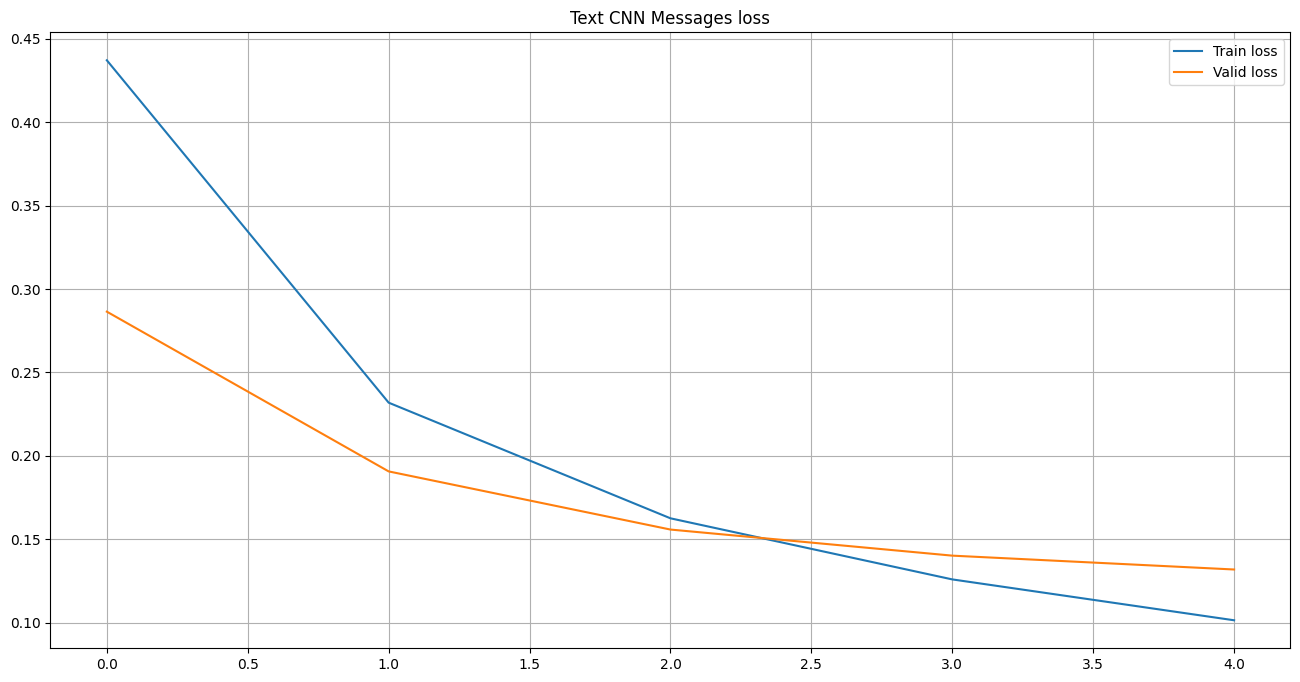

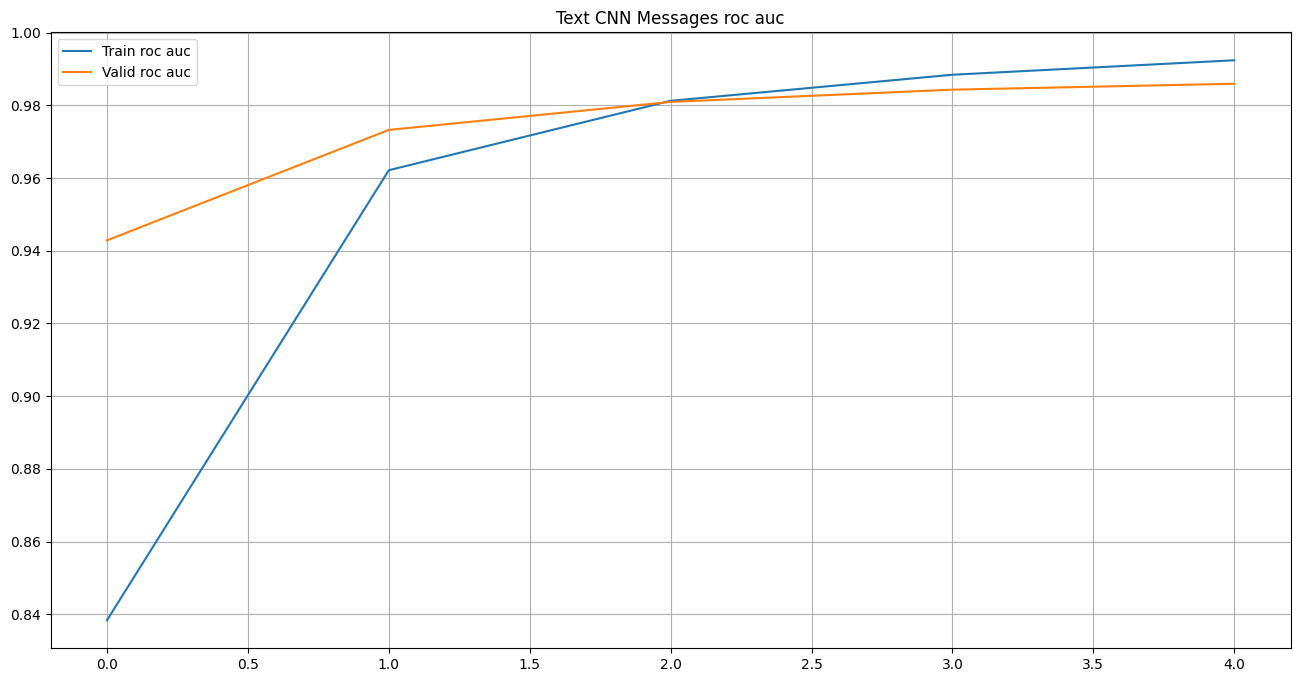

In [171]:
model = model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 5, 'Text CNN Messages')

# BERT + CNN

## Model creating

In [228]:
tokenizer, BERT = AutoTokenizer.from_pretrained('distilbert-base-cased'), DistilBertModel.from_pretrained('distilbert-base-cased')

In [229]:
model = TextCNN(vocab_size=len(dataset.vocab.vocabulary) + 1, embedding_dim=768, pad_idx=pad_idx)

In [230]:
vectors = dataset.vocab.build_vectors_BERT(tokenizer, BERT)

In [231]:
vectors.shape

(11816, 768)

In [232]:
len(dataset.vocab.vocabulary)

11816

In [233]:
model.embedding.weight.shape

torch.Size([11817, 768])

In [234]:
model.embedding.weight.data[:len(vectors)] = torch.from_numpy(vectors)

## Training

In [235]:
import torch.nn as nn
from torch.optim import Adam

In [236]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
# print(torch.cuda.get_device_name())

loss_fn = nn.BCEWithLogitsLoss()

cpu


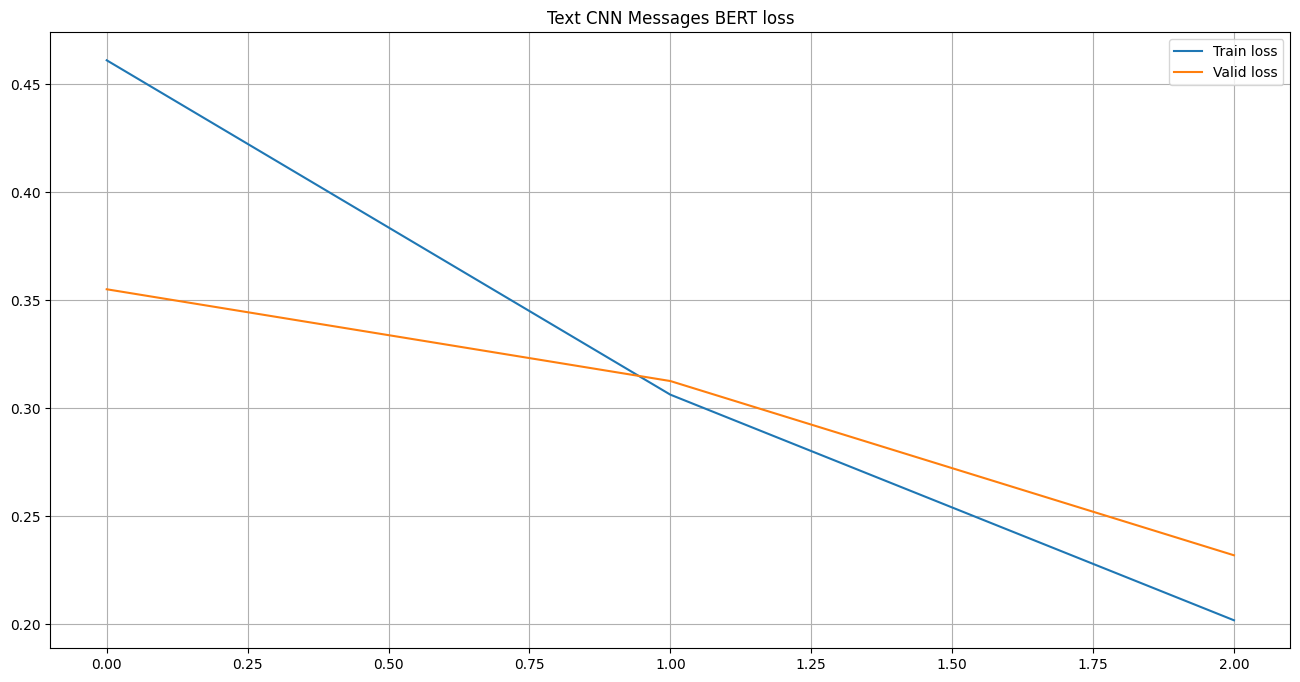

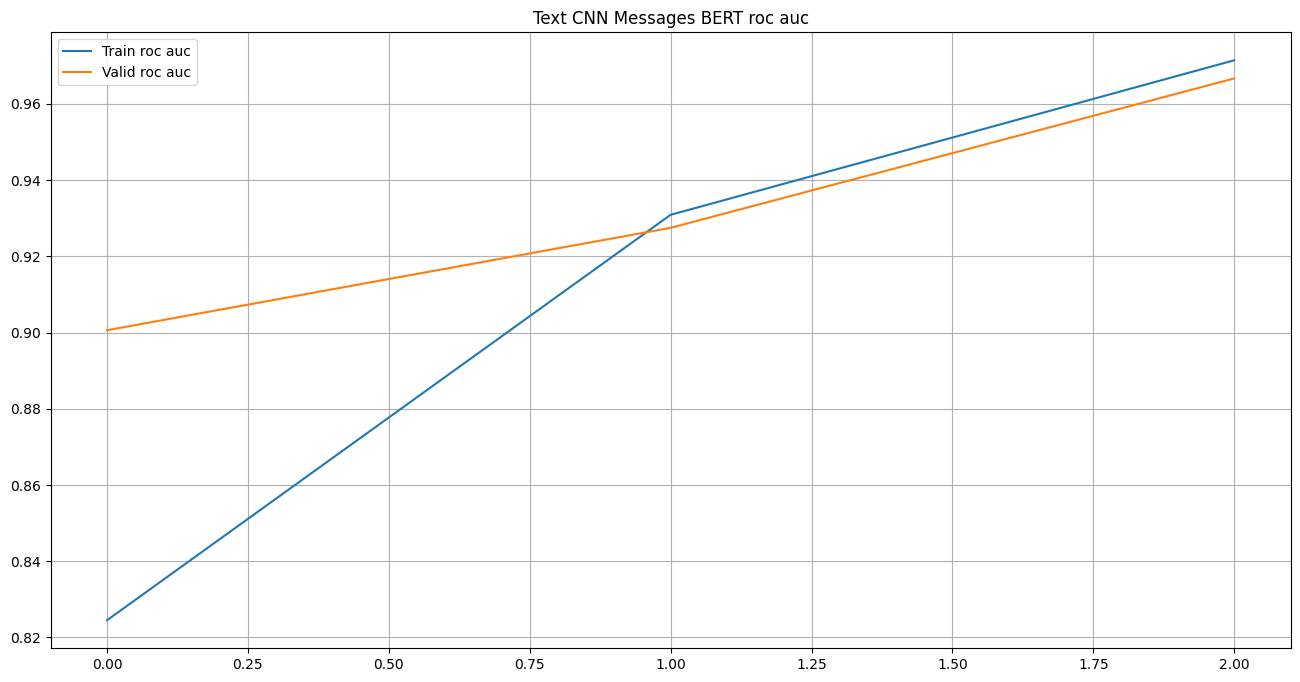

In [237]:
model = model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

whole_train_valid_cycle(model, 3, 'Text CNN Messages BERT')

# Conclusions

В проделанной работе я выполнил следующие этапы:

1. Для создания словаря я написал класс, который убирает лишние символы из текста и оставляет только английские слова.
2. Создал кастомный класс Dataset для загрузки данных батчами в Dataloader
3. Применил два подхода подсчета embedding - fasttext и BERT. В качестве модели я использовал нейронную сеть, состоящую из нескольких сверточных слоев, нескольких слоев maxpooling, dropout слой для регуляризации и финальный полносвязный слой. Также я применял сигмоиду для перевода выхода модели в скоры и подсчета целевой метрики ROC-AUC.
4. В качестве результирующей модели я решил взять подход с применением fasttext по той причине, что для конкретной задачи данная модель обучается быстрее и дает результат ROC-AUC > 0.98 на валидационной выборке. С помощью BERT также можно добиться такого качества, но за большее время.


# Submission

In [193]:
from torch.utils.data import Dataset


class Messages_oot(Dataset):
    def __init__(self, path, vocab):
        self.df = pd.read_csv(path)

        texts = self.df['text'].values

        self.vocab = vocab

    def __getitem__(self, idx):
        text = self.df['text'].loc[idx]

        text = torch.LongTensor(self.vocab.encode(text))

        return text

    def __len__(self):
        return len(self.df)

In [196]:
dataset_oot = Messages_oot('/content/drive/MyDrive/Datasets/VK internship/test_spam.csv', dataset.vocab)

In [203]:
from torch.nn.utils.rnn import pad_sequence

pad_idx = len(dataset.vocab.vocabulary)

def collate_fn_oot(batch):
    texts = pad_sequence([b for b in batch], padding_value=pad_idx, batch_first=True)

    return texts

In [204]:
from torch.utils.data import DataLoader

oot_loader = DataLoader(dataset_oot, batch_size=64, collate_fn=collate_fn_oot, pin_memory=True)

In [216]:
@torch.inference_mode()
def evaluate_oot(model, loader) -> tuple[float, float]:
    model.eval()

    preds = []
    for x in tqdm(loader, desc='Evaluation'):
        x = x.to(device)

        output = model(x)
        scores = torch.sigmoid(output)
        preds.append(scores)

    return torch.concat(preds).reshape(-1, 1)

In [219]:
submission_scores_fasttext = evaluate_oot(model, oot_loader)

Evaluation: 100%|██████████| 64/64 [00:03<00:00, 18.58it/s]


In [220]:
submission_scores_fasttext.shape

torch.Size([4070, 1])

In [ ]:
submission_scores_fasttext

In [223]:
test_df['score'] = submission_scores_fasttext
test_df

,text,score
0,j jim whitehead ejw cse ucsc edu writes j you ...,3.203303e-04
1,original message from bitbitch magnesium net p...,1.709443e-01
2,java for managers vince durasoft who just taug...,4.618006e-04
3,there is a youtuber name saiman says,1.628284e-02
4,underpriced issue with high return on equity t...,9.419020e-01
...,...,...
4065,husband to wifetum meri zindagi hoorwifeor kya...,1.816552e-01
4066,baylor enron case study cindy yes i shall co a...,7.983634e-09
4067,boring as compared to tp,4.919117e-04
4068,hellogorgeous hows u my fone was on charge lst...,3.000549e-03


In [227]:
test_df.to_csv('submission_scores_fasttext.csv', index=False)